In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "service_time arrival_time patience_time")
# example: c = Customer(service_time = 1, arrival_time = 0.5, patience_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(service_time=inf(), arrival_time=-1, patience_time=inf()):
    return Customer(service_time=service_time, arrival_time=arrival_time, patience_time=patience_time)

In [3]:
# Example 2: M/M/c+M not PS (normal) queue (not necessarily) starting as empty


# N0 = starting number in the queue
# Tmax = time horizon

def MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                  number_of_servers_func, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0]  # initial state of the system
    
    # customers currently being served by a server
    remaining_times = [customer(service_rate_func(), 0, inf())
                       for _ in range(min(number_of_servers_func(), N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(inf(), 0, patience_rate_func())
             for _ in range(N0 - number_of_servers_func())]
    
    # times spent by users inside the system
    waiting_times = []
    
    # to calculate the probability someone has to wait in the queue
    p_wait_num = 0
    p_wait_denom = 0
    
    # first event must be an arrival
    next_arrival = arrival_rate_func()
    if len(remaining_times) > 0:
        remaining_times.sort(key=lambda x: x.service_time, reverse=False)
        next_departure = remaining_times[0].service_time
    else:
        next_departure = inf()

    if len(queue) > 0:
        queue.sort(key=lambda x: x.patience_time, reverse=False)
        next_abandonment = queue[0].patience_time
    else:
        next_abandonment = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure, next_abandonment))
            
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            if len(remaining_times) < number_of_servers_func():
                service_time = service_rate_func(N[-1])
                remaining_times.append(customer(T[-1] + service_time, T[-1], inf()))
            else:
                patience_time = patience_rate_func()
                queue.append(customer(inf(), T[-1], T[-1] + patience_time))
                p_wait_num += 1
            p_wait_denom+=1    
            next_arrival = T[-1] + arrival_rate_func()
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            popped_customer = remaining_times.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                queue.sort(key=lambda x: x.arrival_time, reverse=False)
                next_to_enter = queue.pop(0)
                service_time = service_rate_func(N[-1])
                remaining_times.append(customer(T[-1] + service_time, next_to_enter.arrival_time, inf()))
            #print("arrival %.3f DEPARTURE %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### ABANDONMENT ##### 
        else: 
            N.append(N[-1]-1)
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            popped_customer = queue.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            #print("arrival %.3f departure %.3f ABANDONMENT %.3f" % (next_arrival, next_departure, next_abandonment))
        
        if len(remaining_times) > 0:
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            next_departure = remaining_times[0].service_time
        else:
            next_departure = inf()

        if len(queue) > 0:
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            next_abandonment = queue[0].patience_time
        else:
            next_abandonment = inf()

    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, (p_wait_num)/(p_wait_denom)

Model 0A. The surge policy triples the service rate when the queue length is above 8. This ensures the queue length does not go far above 8.
Mean wait time over 100 runs 2.200063


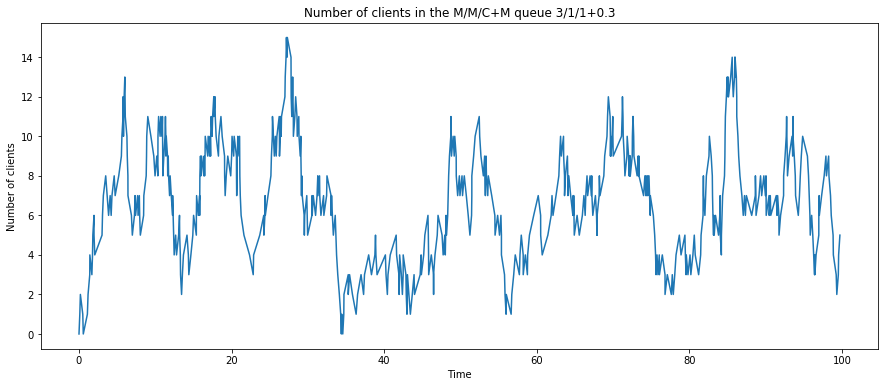

In [4]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 3
mu = 1
mu2 = 3
gamma = 0.3
c = 1
N0 = 0
Tmax = 100

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= 8:
        return exp(mu2)
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("Model 0A. The surge policy triples the service rate when the queue length is above 8. " + 
      "This ensures the queue length does not go far above 8.")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))

Model 0B. The surge policy doubles the service rate when the queue length is above 8. This ensures the queue length does not go far above 8.
Mean wait time 2.265828


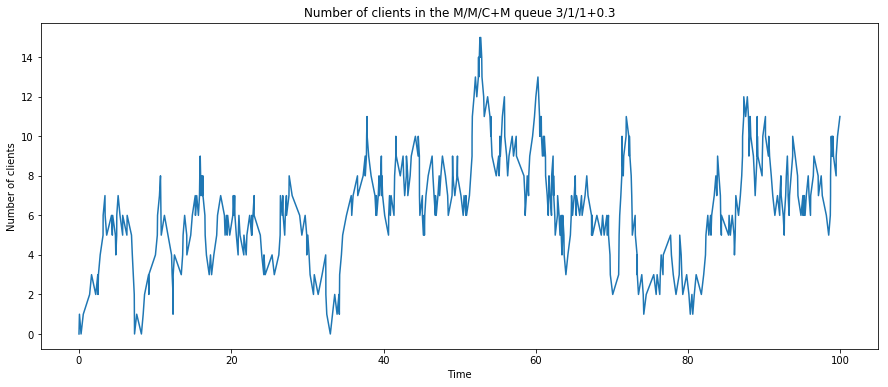

In [5]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 3
mu = 1
mu2 = 2
gamma = 0.3
c = 1
N0 = 0
Tmax = 100

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= 8:
        return exp(mu2)
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("Model 0B. The surge policy doubles the service rate when the queue length is above 8. " + 
      "This ensures the queue length does not go far above 8.")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time %f" % (mean(wait_times)))

This is the same as Model 0 except with no surge policy. The abandonment rate keeps it stable.
Mean wait time 2.475982


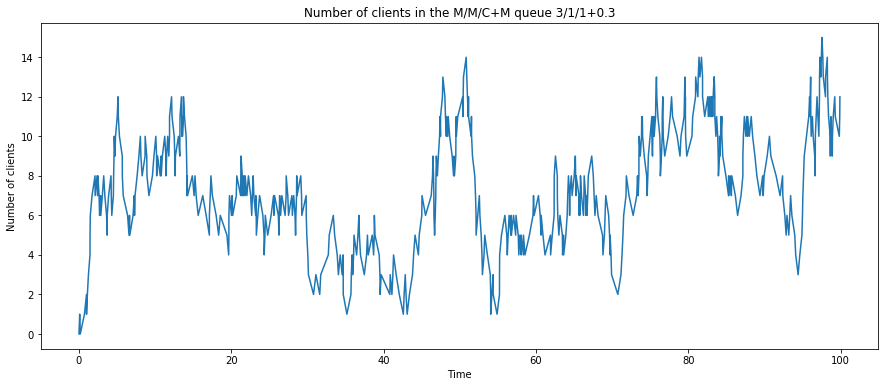

In [6]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 3
mu = 1
mu2 = 2
gamma = 0.3
c = 1
N0 = 0
Tmax = 100

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("This is the same as Model 0 except with no surge policy. " + 
      "The abandonment rate keeps it stable.")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time %f" % (mean(wait_times)))

Model 1. The surge policy doubles the service time when the queue length hits 5. This ensures the queue length does not go far above 5.
Mean wait time 2.325813


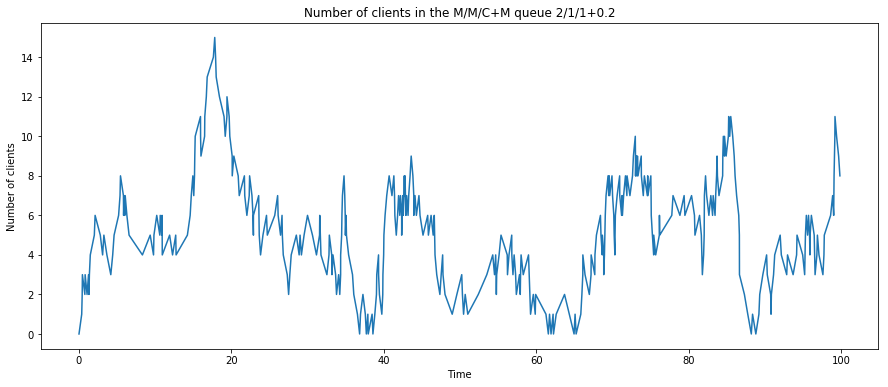

In [7]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 2
mu = 1
mu2 = 2
gamma = 0.2
c = 1
N0 = 0
Tmax = 100

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= 5:
        return exp(mu2)
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("Model 1. The surge policy doubles the service time when the queue length hits 5. " + 
      "This ensures the queue length does not go far above 5.")

wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time %f" % (mean(wait_times)))

This is the same as Model 1 except with no surge policy.
Mean wait time 2.877926


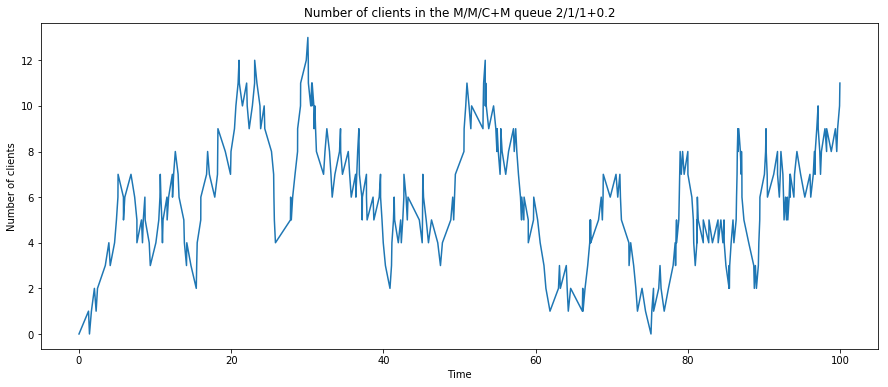

In [8]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 2
mu = 1
mu2 = 2
gamma = 0.2
c = 1
N0 = 0
Tmax = 100

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("This is the same as Model 1 except with no surge policy.")

wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time %f" % (mean(wait_times)))